In [72]:
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt
import os
from PIL import Image
from skimage.segmentation import slic, mark_boundaries
from skimage.filters import threshold_otsu
from scipy.ndimage import gaussian_filter
from datetime import datetime

## Part 1: Refining the epithelium extraction method

In [69]:
# Team 2's Code: Generate Contour-Based Epithelium Mask

def generate_epithelium_mask(image_path):
    
    image = cv2.imread(image_path)
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred_image = cv2.GaussianBlur(gray_image, (45, 45), 0)
    _, thresholded_mask = cv2.threshold(blurred_image, 200, 255, cv2.THRESH_BINARY_INV)
    kernel_huge = np.ones((45, 45), np.uint8)
    cleaned_mask = cv2.morphologyEx(thresholded_mask, cv2.MORPH_CLOSE, kernel_huge)
    cleaned_mask = cv2.morphologyEx(cleaned_mask, cv2.MORPH_OPEN, kernel_huge)

    kernel_medium = np.ones((25, 25), np.uint8)
    generalized_cleaned_mask = cv2.morphologyEx(cleaned_mask, cv2.MORPH_CLOSE, kernel_medium)
    generalized_cleaned_mask = cv2.morphologyEx(generalized_cleaned_mask, cv2.MORPH_OPEN, kernel_medium)

    # Find contours for the generalized mask
    contours, _ = cv2.findContours(generalized_cleaned_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Draw contours on a separate mask
    contour_mask = np.zeros_like(generalized_cleaned_mask)
    cv2.drawContours(contour_mask, contours, -1, 255, thickness=cv2.FILLED)
    
    return contour_mask, contours, image



# My code from last week: Create Superpixels 
# Modification: Cut Along Contour Boundaries
def create_and_cut_superpixels(image, contour_mask, contours, num_segments=750):
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    segments = slic(image_rgb, n_segments=num_segments, compactness=10, start_label=1)
    
    segmented_image = np.zeros_like(image_rgb)
    lower_purple = np.array([125, 40, 40])
    upper_purple = np.array([155, 255, 255])

    for segment_value in np.unique(segments):
        segment_mask = (segments == segment_value)
        
        # Separate parts inside and outside the contour using the contour mask
        inside_mask = np.logical_and(segment_mask, contour_mask > 0)
        outside_mask = np.logical_and(segment_mask, contour_mask == 0)

        # Process inside region
        if np.sum(inside_mask) > 0:
            inside_segment = np.zeros_like(image_rgb)
            inside_segment[inside_mask] = image_rgb[inside_mask]
            inside_hsv = cv2.cvtColor(inside_segment, cv2.COLOR_RGB2HSV)
            purple_inside_mask = cv2.inRange(inside_hsv, lower_purple, upper_purple)
            
            # Calculate purple concentration inside
            total_pixels_inside = np.sum(inside_segment[:, :, 0] > 0)
            purple_pixels_inside = np.sum(purple_inside_mask > 0)
            purple_concentration_inside = purple_pixels_inside / total_pixels_inside if total_pixels_inside > 0 else 0

            # Assign colors based on purple concentration for inside
            if purple_concentration_inside > 0.15:
                segmented_image[inside_mask] = image_rgb[inside_mask]
            elif purple_concentration_inside > 0.015:
                segmented_image[inside_mask] = [255, 255, 255]
            else:
                segmented_image[inside_mask] = [0, 0, 0]

        # Process outside region (background)
        if np.sum(outside_mask) > 0:
            segmented_image[outside_mask] = [0, 0, 0]  # Assign black to outside background

    plt.figure(figsize=(10, 10))
    plt.imshow(segmented_image)
    plt.title("Final Segmented Epithelium Image with Contour-Based Cuts")
    plt.axis('off')
    plt.show()
    
    return segmented_image

# Combining both steps
def combined_contour_superpixel_segmentation(image_path):
    contour_mask, contours, original_image = generate_epithelium_mask(image_path)
    segmented_image = create_and_cut_superpixels(original_image, contour_mask, contours)
    cv2.imwrite('Intermediate-step.tif', cv2.cvtColor(segmented_image, cv2.COLOR_RGB2BGR))

## Part 2: Sampling using **<font color ='purple'>local width</font>**

In [44]:
def load_image_with_presegmentation(image_path):
    image = cv2.imread(image_path)
    grayscale_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return image, grayscale_image

In [63]:
# Check if a new sample overlaps with any existing sample
def is_overlapping(new_coords, existing_coords, min_distance=50):
    x1_new, y1_new, x2_new, y2_new = new_coords
    for (x1_old, y1_old, x2_old, y2_old) in existing_coords:
        
        # Calculate the distance between centers of rectangles
        center_x_old, center_y_old = (x1_old + x2_old) // 2, (y1_old + y2_old) // 2
        center_x_new, center_y_new = (x1_new + x2_new) // 2, (y1_new + y2_new) // 2
        distance = np.sqrt((center_x_new - center_x_old)**2 + (center_y_new - center_y_old)**2)
        
        if distance < min_distance:
            return True
        
    return False

In [64]:
# Alyssa's Sampling Method

def sample_across_epithelium(image, grayscale_image, num_samples=5, min_size=(40, 40), max_size=(1500, 1500)):
    samples = []
    sample_coords = []
    height, width = image.shape[:2]

    edges = cv2.Canny(grayscale_image, 100, 200)  # Edge detection to find epithelium boundaries
    
    for _ in range(num_samples):
        
        for attempt in range(500):
            
            # Randomly select a center point for the sample box in the black area (background)
            center_x = random.randint(min_size[0] // 2, width - min_size[0] // 2)
            center_y = random.randint(min_size[1] // 2, height - min_size[1] // 2)

            # Define the sample box
            sample_width = random.randint(min_size[0], max_size[0])
            sample_height = random.randint(min_size[1], max_size[1])

            x1 = max(0, center_x - sample_width // 2)
            y1 = max(0, center_y - sample_height // 2)
            x2 = min(width, center_x + sample_width // 2)
            y2 = min(height, center_y + sample_height // 2)
            
            # Skip sample if it overlaps with an existing sample
            if is_overlapping((x1, y1, x2, y2), sample_coords):
                continue  
            
            # Crop the sample and check edge detection within the box
            sample_rgb = image[y1:y2, x1:x2]
            sample_edges = edges[y1:y2, x1:x2]
            
            # Ensure the sample contains both black and white regions
            white_pixels = np.sum(np.all(sample_rgb == [255, 255, 255], axis=-1))  # White pixels (stroma)
            black_pixels = np.sum(np.all(sample_rgb == [0, 0, 0], axis=-1))  # Black pixels (background)

            # Enforce a roughly equal proportion of black and white pixels
            # Skip this sample if the balance is off
            if abs(white_pixels - black_pixels) > (0.2 * (white_pixels + black_pixels)):
                continue

            # Convert the sample to HSV for purple detection
            sample_hsv = cv2.cvtColor(sample_rgb, cv2.COLOR_RGB2HSV)
            
            # Ensure that purple pixels make up more than 20% of the sample
            total_pixels = sample_rgb.shape[0] * sample_rgb.shape[1]
            purple_mask = cv2.inRange(sample_hsv, np.array([125, 40, 40]), np.array([155, 255, 255]))
            purple_pixels = np.sum(purple_mask > 0)

            if (purple_pixels / total_pixels) >= 0.2 and np.sum(sample_edges) > 100 and (white_pixels / total_pixels) > 0.01 and (black_pixels / total_pixels) > 0.01:
                samples.append(sample_rgb)
                sample_coords.append((x1, y1, x2, y2))
                break  
    
    return samples, sample_coords

In [73]:
def save_samples(samples):
    
    base_name = "Samples"
    folder_count = 1
    while os.path.exists(f"{base_name}_{folder_count}"):
        folder_count += 1
    folder_name = f"{base_name}_{folder_count}"
    os.makedirs(folder_name)

    for i, sample in enumerate(samples):
        file_path = os.path.join(folder_name, f"sample_{i+1}.tif")
        cv2.imwrite(file_path, sample)
    
    print(f"Saved {len(samples)} samples to the '{folder_name}' folder.")

In [74]:
def display_image_with_boxes(image_path, num_samples=10):

    image, grayscale_image = load_image_with_presegmentation(image_path)
    samples, sample_coords = sample_across_epithelium(image, grayscale_image, num_samples=num_samples)

    # Draw red boxes on the original image
    image_with_boxes = image.copy()
    for (x1, y1, x2, y2) in sample_coords:
        cv2.rectangle(image_with_boxes, (x1, y1), (x2, y2), (255, 0, 0), 2)  # Red boxes
        
    # Saving the samples to a folder on my computer
    save_samples(samples)

    plt.imshow(cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB))  # Show the image in RGB
    cv2.imwrite("Image_with_Samples.tif", cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB))
    plt.title("Original Image with Sampling Boxes")
    plt.axis('off')
    plt.show()

Saved 6 samples to the 'Samples' folder.


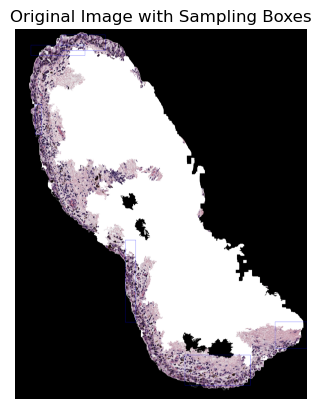

In [66]:
# EXAMPLE: Run the function to display the image with boxes
display_image_with_boxes('segmented_image_with_contour_cut.tif')

## Part 3: Putting everything together

In [75]:
def go(image_path):

    combined_contour_superpixel_segmentation(image_path)
    display_image_with_boxes('Intermediate-step.tif')
    
    return

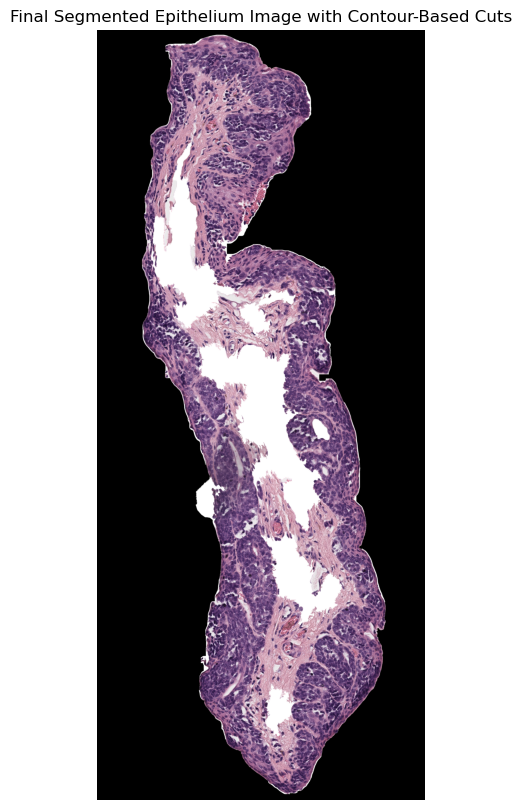

Saved 10 samples to the 'Samples_1' folder.


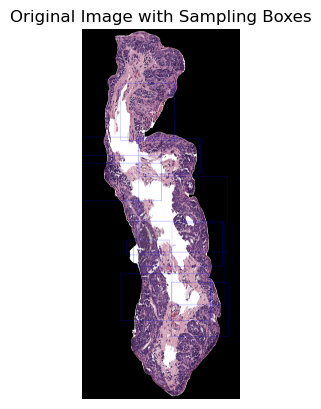

In [76]:
go('image2.tif')

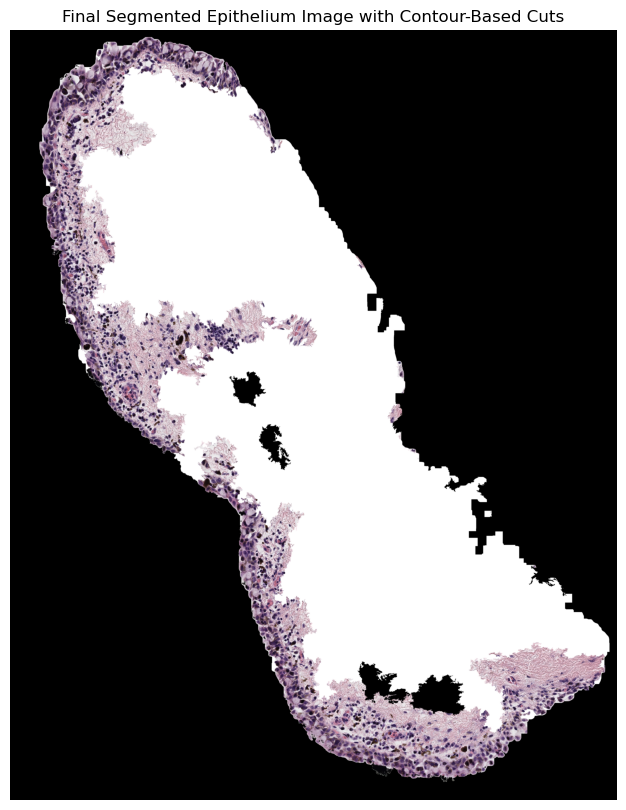

Saved 7 samples to the 'Samples_3' folder.


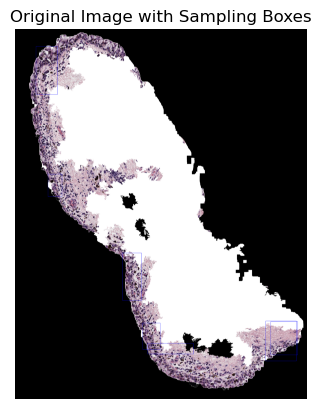

In [78]:
go('HighQualitySample.tif')

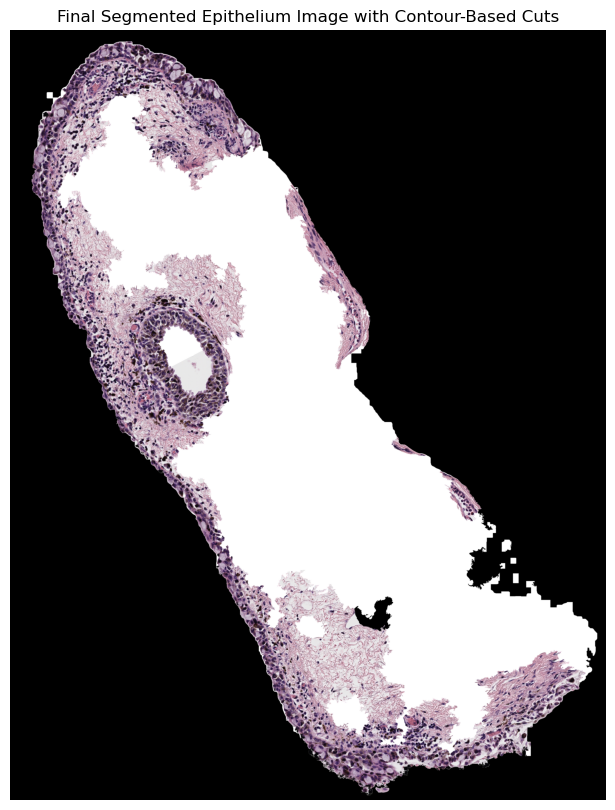

Saved 10 samples to the 'Samples' folder.


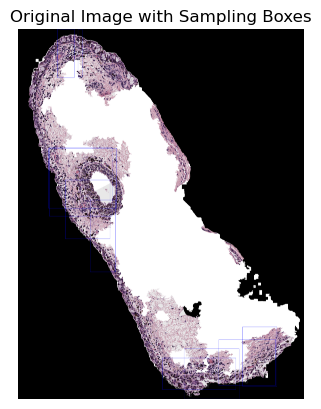

In [71]:
go('HighQualitySample2.tif')

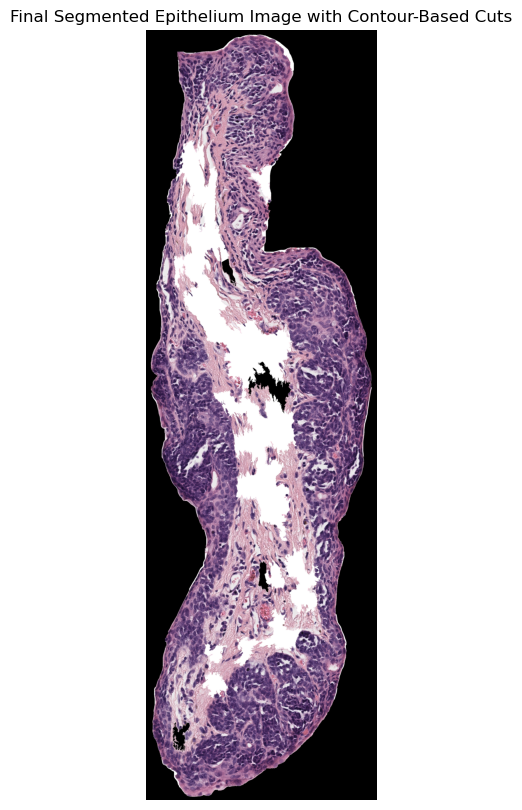

Saved 10 samples to the 'Samples_2' folder.


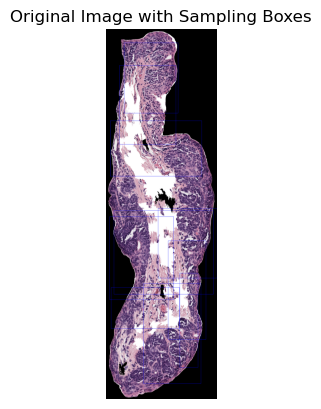

In [77]:
go('h2114153  h&e_ROI_1.tif')